### xPassRush
  
*Gian Favero and Michael Montemurri, Mila, 2024*

This notebook performs the following steps for the 2025 NFL Big Data Bowl competition:
1. Load cleaned data from the pipeline.
2. Reproduce the xPassRush metric from the 2023 Big Data Bowl Finalist submission. 
3. Save xPassRush as a feature in a preprocessed dataset for downstream use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

root_dir = os.getcwd()
print(root_dir)

# Go back a directory to access the data folder
os.chdir(os.path.join(root_dir, '..'))

/cim/faverog/BigData25/notebooks


In [2]:
#import dataset
df_raw = pd.read_csv('data/processed/df_clean.csv')

cols_to_use = [
      'gameId', 'playId', 'frameId', 'nflId', 'displayName',
      'position', 'club', 'possessionTeam', 'defensiveTeam',
      'preSnapHomeScore', 'preSnapVisitorScore', 'quarter',
      'gameClock', 'down', 'yardsToGo', 'yardlineNumber',
      'yardlineSide', 'offenseFormation', 'receiverAlignment',
      'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
      'o_clean', 'a_clean', 's_clean', 'x_clean', 'y_clean', 'dir_clean',
      'playDescription', 'passLocationType', 'rushLocationType', 
      'pff_runConceptPrimary', 'yardsGained', 'wasInitialPassRusher', 'event'
      ]

df = df_raw[cols_to_use]

We need to group by game_id, play_id, and player_id, then find the x coordinate for the row where event = "line_set" and the row where event = "ball_snapped". Then, we can subtract the x coordinate for the "line_set" row from the x coordinate for the "ball_snapped" row. We can then add this value to the dataframe as a new column

Actually since we're removing all frames between line_set and ball snapped we can just take the difference in the x coordinates between the two rows. We need to take into consideration that since the plays are all going from left to right, the defense is always facing the other way, so when we take the difference in x coords, we need to * by -1 to get a positive value if the defender is creeping forward which is more intuitive.

In [3]:
# Group by 'gameId', 'playId', and 'nflId' to calculate the difference in x coordinates for each player
# Using .agg() instead of .apply() to avoid warnings
crept_up_df = df.groupby(['gameId', 'playId', 'nflId'])['x_clean'].agg(lambda x: x.diff().iloc[-1]).reset_index()

# Multiply the resulting differences by -1
crept_up_df['creptDist'] = crept_up_df['x_clean'] * -1

# Now filter rows where the event is 'line_set' (we assume 'event' column exists)
df = df[df['event'] == 'line_set'].copy()  # Make a copy to avoid SettingWithCopyWarning

# Merge the 'creptDist' values into the filtered dataframe based on ['gameId', 'playId', 'nflId']
df = df.merge(crept_up_df[['gameId', 'playId', 'nflId', 'creptDist']], on=['gameId', 'playId', 'nflId'], how='left')

#confirmed with animation that the creptDist is correct

Now, calculate horizontal distance to the ball for each player. We get the y coord. of the ball by using the y coord. of the center.

So we want to group by game_id, play_id, get the y coord of the player with "position" = "C", then loop through each player on the defense and calculate the horizontal distance to the ball by subtracting their y coord. with the y coord. of the center. Then we'll add this value to the dataframe as a new column.

In [4]:
# Group by 'gameId' and 'playId', then find the y coord of the center ('C') player
def get_center_y(group):
    center = group[group['position'] == 'C']
    if not center.empty:
        return center['y_clean'].iloc[0]
    return None  # In case there's no center player

# Apply this function to each group to get the y_clean for the center player
center_y_dict = df.groupby(['gameId', 'playId']).apply(get_center_y).to_dict()

# Map the center_y value to the dataframe based on 'gameId' and 'playId'
df['center_y'] = df.set_index(['gameId', 'playId']).index.map(center_y_dict)

# Now, calculate the horizontal distance to the ball for each player
# Check if 'center_y' is assigned properly, otherwise hDist will be NaN
df['hDist'] = df['y_clean'] - df['center_y']

#confirmed with animation that the hDist is correct

/tmp/ipykernel_3592942/3243226098.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  center_y_dict = df.groupby(['gameId', 'playId']).apply(get_center_y).to_dict()


Now we need to calculate distance from teh line of scrimmage, which is the difference between the x coordinate of the player and the line of scrimmage. Let's do the same thing as before, using the center's x coordinate as the line of scrimmage.

In [5]:
# Group by 'gameId' and 'playId', then find the x coord of the center ('C') player
def get_center_x(group):
    center = group[group['position'] == 'C']
    if not center.empty:
        return center['x_clean'].iloc[0]
    return None  # In case there's no center player

# Apply this function to each group to get the x_clean for the center player
center_x_dict = df.groupby(['gameId', 'playId']).apply(get_center_x).to_dict()

# Map the center_x value to the dataframe based on 'gameId' and 'playId'
df['center_x'] = df.set_index(['gameId', 'playId']).index.map(center_x_dict)

# Now, calculate the distance from the line of scrimmage for each player

df['losDist'] = df['x_clean'] - df['center_x']

#confirmed with animation that these values are correct

/tmp/ipykernel_3592942/2616213925.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  center_x_dict = df.groupby(['gameId', 'playId']).apply(get_center_x).to_dict()


In [6]:
# Rename positions to a common and more primary format
# Group all specified positions into the desired categories
position_mapping = {
    'FS': 'S',    # Safety (FS)
    'SS': 'S',    # Safety (SS)
    'LB': 'DE',   # Linebacker (LB) -> Defensive End (DE)
    'MLB': 'ILB', # Middle Linebacker (MLB) -> Inside Linebacker (ILB)
    'NT': 'IDL',  # Nose Tackle (NT) -> Interior Defensive Line (IDL)
    'DT': 'IDL',  # Defensive Tackle (DT) -> Interior Defensive Line (IDL)
    'DB': 'CB'    # Defensive Back (DB) -> Cornerback (CB)
}

# Grouping and renaming positions with .loc to avoid SettingWithCopyWarning
df.loc[:, 'position'] = df['position'].replace(position_mapping)

Now let's get only our features of interest for predicting wasInitialPassRusher. Also, we can plot some ground truth statistics for an idea of what the outputs should be.

position
CB     22503
S      18620
IDL    12998
ILB    12841
DE     12042
OLB    11935
Name: count, dtype: int64
position  wasInitialPassRusher
CB        0.0                     0.982002
          1.0                     0.017998
DE        1.0                     0.969108
          0.0                     0.030892
IDL       1.0                     0.995692
          0.0                     0.004308
ILB       0.0                     0.865353
          1.0                     0.134647
OLB       1.0                     0.693255
          0.0                     0.306745
S         0.0                     0.964501
          1.0                     0.035499
Name: proportion, dtype: float64


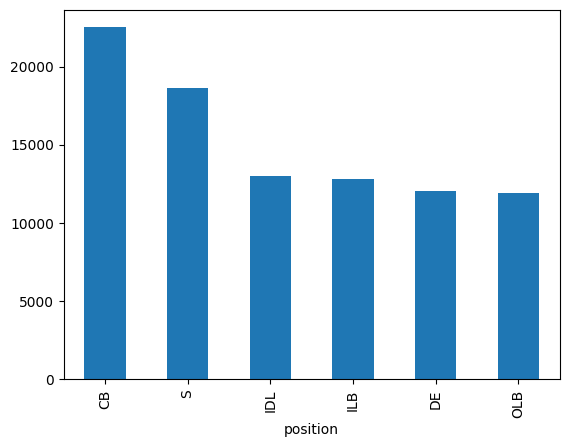

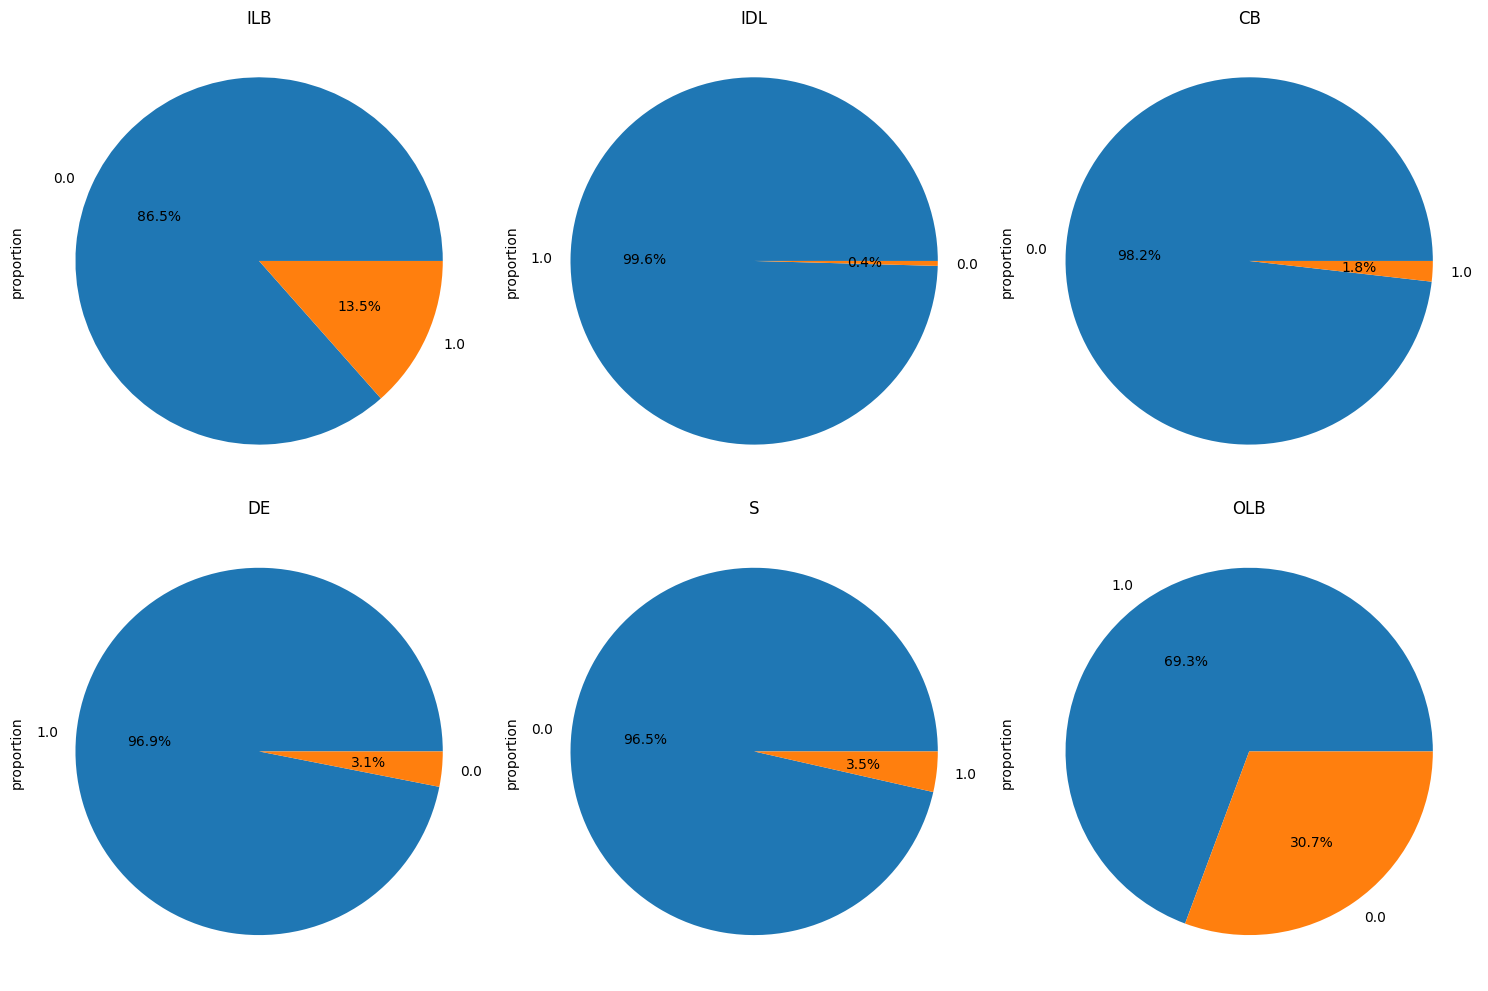

wasInitialPassRusher
0.0    0.607638
1.0    0.392362
Name: proportion, dtype: float64


In [7]:
features = ['wasInitialPassRusher','position','creptDist', 'hDist', 'losDist', 'o_clean']

df_model = df[features]

# Drop rows with NaN in 'wasInitialPassRusher' using .loc
df_model = df_model.loc[df_model['wasInitialPassRusher'].notna()]

# Remove all WR (Wide Receiver)
df_model = df_model[df_model['position'] != 'WR']

# Data analysis of the final dataframe to be used for training the model(s)

# Check the distribution of the position of the players in the dataset
print(df_model['position'].value_counts())
# plot the distribution of the position of the players in the dataset
df_model['position'].value_counts().plot(kind='bar')

# Check the distribution of the target variable in each position
print(df_model.groupby('position')['wasInitialPassRusher'].value_counts(normalize=True))
# plot the distribution of the target variable in each position as a separate pie chart
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
positions = df_model['position'].unique()
for i, pos in enumerate(positions):
    ax = axs[i//3, i%3]
    df_model[df_model['position'] == pos]['wasInitialPassRusher'].value_counts(normalize=True).plot(kind='pie', ax=ax, autopct='%1.1f%%', title=pos)
plt.tight_layout()
plt.show()

# Check the distribution of the target variable overall
print(df_model['wasInitialPassRusher'].value_counts(normalize=True))

In [8]:
import joblib
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import numpy as np

# Get the unique positions
positions = df_model['position'].unique()

# Get only positions that have more than 1 unique value in the target
positions = [position for position in positions if df_model[df_model['position'] == position]['wasInitialPassRusher'].nunique() > 1]

# Loop over each position
for position in positions:
    print(f'Position: {position}')

    # Filter the dataset for the current position
    df_position = df_model[df_model['position'] == position].copy()  # Use a copy to avoid modifying df_model

    # Drop the 'position' column (it’s not needed for modeling)
    df_position.drop('position', axis=1, inplace=True)

    # Define the features (X) and target (y)
    X = df_position.drop('wasInitialPassRusher', axis=1)
    y = df_position['wasInitialPassRusher']

    # Split into training and testing sets (hold out a test set for final evaluation)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model
    model = XGBClassifier()

    # Get param grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200, 250],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'min_child_weight': [1, 3, 5],
    }

    # Set up the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid, 
        n_iter=10, 
        scoring='roc_auc', 
        n_jobs=-1, 
        cv=cv, 
        random_state=42
    )

    # Fit the model using RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Display the best parameters and score
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validated AUC: {random_search.best_score_:.4f}")
    
    # Get cross-validated predictions using cross_val_predict
    best_model = random_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=cv)

    # Calculate Accuracy on the training data across folds
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f'Training Accuracy (CV): {accuracy_train * 100.0:.2f}%')

    # Train the model on the entire training set (after cross-validation)
    best_model.fit(X_train, y_train)

    # Save the trained model using joblib
    model_filename = f'models/model_{position}.joblib'  # Save with the position name
    joblib.dump(best_model, model_filename)
    print(f'Model for position {position} saved as {model_filename}')

    # Evaluate the final model on the test set
    y_pred_test = best_model.predict(X_test)
    y_pred_prob_test = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # print the average y_pred_prob_test
    print(f'Average y_pred_prob_test: {np.mean(y_pred_prob_test):.4f}')

    # Check if both classes are present in the test set before calculating AUC
    if y_test.nunique() > 1:
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        print(f'Test AUC: {auc_test:.4f}')

        # Get confusion matrix
        cm = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
        print('Confusion Matrix:')
        print(cm)
    else:
        auc_test = np.nan
        print(f'Test AUC: N/A (Only one class present in y_test)')

    # Calculate Accuracy on the test set
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f'Test Accuracy: {accuracy_test * 100.0:.2f}%')

    print('\n')

Position: ILB
Best Parameters: {'subsample': 0.8, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01}
Best Cross-Validated AUC: 0.8322
Training Accuracy (CV): 86.84%
Model for position ILB saved as models/model_ILB.joblib
Average y_pred_prob_test: 0.1402
Test AUC: 0.8470
Confusion Matrix:
Predicted     0   1
Actual             
0.0        2202  31
1.0         292  44
Test Accuracy: 87.43%


Position: IDL
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1}
Best Cross-Validated AUC: 0.5570
Training Accuracy (CV): 99.59%
Model for position IDL saved as models/model_IDL.joblib
Average y_pred_prob_test: 0.9981
Test AUC: 0.5639
Confusion Matrix:
Predicted     1
Actual         
0.0          13
1.0        2587
Test Accuracy: 99.50%


Position: CB
Best Parameters: {'subsample': 0.8, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01}
Best Cross-Validated AUC: 0.8727
T

In [ ]:
import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier
import numpy as np

# Get the unique positions
positions = df_model['position'].unique()

# Get only positions that have more than 1 unique value in the target
positions = [position for position in positions if df_model[df_model['position'] == position]['wasInitialPassRusher'].nunique() > 1]

# Loop over each position
for position in positions:
    # Filter the dataset for the current position
    df_position = df_model[df_model['position'] == position].copy()  # Use a copy to avoid modifying df_model

    # Drop the 'position' column (it’s not needed for modeling)
    df_position.drop('position', axis=1, inplace=True)

    # Define the features (X) and target (y)
    X = df_position.drop('wasInitialPassRusher', axis=1)
    y = df_position['wasInitialPassRusher']

    # Split into training and testing sets (hold out a test set for final evaluation)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model
    model = XGBClassifier()

    # Set up the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

    # Check if both classes (0 and 1) are present in the training data before calculating AUC
    print(f'Position: {position}')
    
    # Check if both classes are present in the training set
    if y_train.nunique() > 1:
        try:
            auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
            print(f'Average AUC (CV): {auc_scores.mean():.4f} ± {auc_scores.std():.4f}')
        except ValueError as e:
            print(f"Error calculating AUC for {position}: {e}")
            auc_scores = np.nan
            print(f'Average AUC: {auc_scores} (Error: Only one class present in some folds)')
    else:
        auc_scores = np.nan
        print(f'Average AUC: {auc_scores} (Only one class present in target)')
    
    # Get cross-validated predictions using cross_val_predict
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=cv)

    # Calculate Accuracy on the training data across folds
    accuracy_train = accuracy_score(y_train, y_pred_train)
    print(f'Training Accuracy (CV): {accuracy_train * 100.0:.2f}%')

    # Train the model on the entire training set (after cross-validation)
    model.fit(X_train, y_train)

    # Save the trained model using joblib
    model_filename = f'models/model_{position}.joblib'  # Save with the position name
    joblib.dump(model, model_filename)
    print(f'Model for position {position} saved as {model_filename}')

    # Evaluate the final model on the test set
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

    # Check if both classes are present in the test set before calculating AUC
    if y_test.nunique() > 1:
        auc_test = roc_auc_score(y_test, y_pred_prob_test)
        print(f'Test AUC: {auc_test:.4f}')
    else:
        auc_test = np.nan
        print(f'Test AUC: N/A (Only one class present in y_test)')

    # Calculate Accuracy on the test set
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print(f'Test Accuracy: {accuracy_test * 100.0:.2f}%')

    print('\n')




Position: ILB
Average AUC (CV): 0.7158 ± 0.0079
Training Accuracy (CV): 85.20%
Model for position ILB saved as models/model_ILB.joblib
Test AUC: 0.7174
Test Accuracy: 84.85%


Position: IDL
Average AUC (CV): 0.4922 ± 0.0516
Training Accuracy (CV): 99.53%
Model for position IDL saved as models/model_IDL.joblib
Test AUC: 0.5415
Test Accuracy: 99.73%


Position: CB
Average AUC (CV): 0.7671 ± 0.0206
Training Accuracy (CV): 98.08%
Model for position CB saved as models/model_CB.joblib
Test AUC: 0.7478
Test Accuracy: 98.33%


Position: DE
Average AUC (CV): 0.5860 ± 0.0192
Training Accuracy (CV): 96.68%
Model for position DE saved as models/model_DE.joblib
Test AUC: 0.5925
Test Accuracy: 96.70%


Position: S
Average AUC (CV): 0.9034 ± 0.0109
Training Accuracy (CV): 96.04%
Model for position S saved as models/model_S.joblib
Test AUC: 0.9048
Test Accuracy: 95.82%


Position: OLB
Average AUC (CV): 0.8096 ± 0.0113
Training Accuracy (CV): 81.45%
Model for position OLB saved as models/model_OLB.jobl

In [9]:
import joblib
import numpy as np

# Define the features used for training
training_features = ['creptDist', 'hDist', 'losDist', 'o_clean']

# Function to predict InitialPassRusher probability for each row
def predict_xPassRush(row, model_dict):
    # Get the player's position for the current row
    position = row['position']
    
    # If the model exists for this position, use it to predict the probability
    if position in model_dict:
        model = model_dict[position]
        
        # Select only the features used for training (excluding 'position')
        X_row = row[training_features].values.reshape(1, -1)  # reshape for a single sample
        prob = model.predict_proba(X_row)[:, 1]  # Get probability for the positive class (InitialPassRush = 1)
        
        return prob[0]
    else:
        # If no model is available for the position, return NaN or 0 as a fallback
        return np.nan

# Load all the models (this assumes they were saved in the previous step)
model_dict = {}
positions = df_model['position'].unique()

for position in positions:
    model_filename = f'models/model_{position}.joblib'
    try:
        model_dict[position] = joblib.load(model_filename)
    except FileNotFoundError:
        print(f'Model for position {position} not found.')

# Now apply the prediction for each row in the original DataFrame
df['xPassRush'] = df.apply(lambda row: predict_xPassRush(row, model_dict), axis=1)


In [10]:
# Check the results for a specific player (e.g., Aaron Donald)
print(df[['gameId', 'playId', 'nflId', 'position', 'xPassRush']][df['displayName'] == 'Aaron Donald'])

            gameId  playId  nflId position  xPassRush
12      2022090800      56  41239      IDL   0.999561
34      2022090800      80  41239      IDL   0.998439
56      2022090800     101  41239      IDL   0.999633
78      2022090800     122  41239      IDL   0.999891
100     2022090800     167  41239      IDL   0.999914
...            ...     ...    ...      ...        ...
289960  2022110609    4058  41239      IDL   0.999517
289982  2022110609    4104  41239      IDL   0.999931
290004  2022110609    4133  41239      IDL   0.999945
290026  2022110609    4162  41239      IDL   0.999859
290048  2022110609    4224  41239      IDL   0.999415

[339 rows x 5 columns]


In [11]:
#save the df with the new feature as a csv
df.to_csv('data/processed/df_xPassRush.csv', index=False)